In [4]:
import glob
import subprocess
from ROOT import *
import numpy as np
import ROOT
import matplotlib.pyplot as plt     
import os

ImportError: dynamic module does not define module export function (PyInit_libPyROOT)

In [2]:
#define the path for difference data version
Caspian="/home/caspian/data/"
Luke='/cms/data/store/user/lukesaun/data/'      # Luke's file has non-0 weight information
Wanzijie='/home/wanzj/old-data/reconstructed0/' 
WZJ='/home/wanzj/data/'
Experiment_data='/home/caspian/nimSkim_data.root'
Simulation_data='/home/wanzj/DPHodo.root'
SimBkg='/home/wanzj/SimBkg1.root'

In [3]:
#Cross Section calculation
def CrossSection_Brem():
    #read the data
    mass = []
    N_Aprime = []
    debug = True # print some data and draw the graph for debug mode
    with open('/home/wanzj/practice/CrossSection_Brem.dat','rt') as f:
        new_line = f.readline()
        while new_line:
            if new_line[0] !='#': 
                data=new_line.split(',')
                mass.append(float(data[0]))
                N_Aprime.append(float(data[1]))
            new_line = f.readline()
    f.close()
    n_points=len(mass)
    
    low_mass = np.array(mass[:24])
    lowmass_N = np.array(N_Aprime[:24])
    high_mass = np.array(mass[23:])
    highmass_N = np.array(N_Aprime[23:])
    
    brem_splineL=ROOT.TSpline3("BremCrossSection_lowmass",low_mass,lowmass_N,len(low_mass),"",0.0,lowmass_N[-1])
    brem_splineH=ROOT.TSpline3("BremCrossSection_highmass",high_mass,highmass_N,len(high_mass),"",0.0,highmass_N[-1])
    
    if debug:
        plt.plot(mass,N_Aprime,'r*',label='sample point')
        plt.yscale("log")
        plt.xscale("log")
        plt.xlabel("mass(GeV)")
        plt.ylabel("N_Aprime")
        
        
        x=np.linspace(mass[0],3,200)
        y=[]
        for i in range(200):
            if x[i]<mass[23]:
                y.append(brem_splineL.Eval(x[i]))
            else: 
                y.append(brem_splineH.Eval(x[i]))
                
        plt.plot(x,y,'b-',label='Tspline evaluation')
        plt.legend()
    
    return brem_splineL, brem_splineH

def CrossSection_Eta():
    #read the data
    mass = []
    N_Aprime = []
    debug = True  # print some data and draw the graph for debug mode
    with open('/home/wanzj/practice/CrossSection_Eta.dat','rt') as f:
        new_line = f.readline()
        while new_line:
            if new_line[0] !='#': 
                data=new_line.split(',')
                mass.append(float(data[0]))
                N_Aprime.append(float(data[1]))
            new_line = f.readline()
    f.close()
    n_points=len(mass)
    
    eta_spline=ROOT.TSpline3("EtaCrossSection",np.array(mass),np.array(N_Aprime),n_points,"",0.0,N_Aprime[n_points-1])
    
    if debug:
        plt.plot(mass,N_Aprime,'r*',label='sample point')
        plt.yscale("log")
        plt.xscale("log")
        plt.xlabel("mass(GeV)")
        plt.ylabel("N_Aprime")
        #plt.rcParams["figure.figsize"] = (7,5)
        
        x=np.linspace(mass[0],0.55,100)
        y=[]
        for i in range(100):
            y.append(eta_spline.Eval(x[i]))
        plt.plot(x,y,'b-',label='Tspline evaluation')
        plt.legend()
        
    return eta_spline

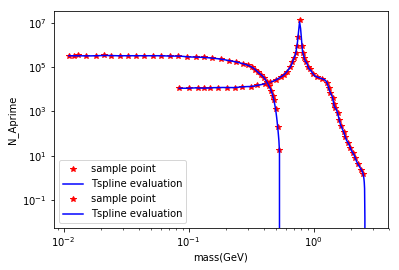

In [4]:
BremCrossSection_splineL,BremCrossSection_splineH = CrossSection_Brem()
EtaCrossSection_spline = CrossSection_Eta()

In [5]:
print BremCrossSection_splineH.Eval(2.15)

8.10587636909


In [6]:
print EtaCrossSection_spline.Eval(0.51)

389.07071944


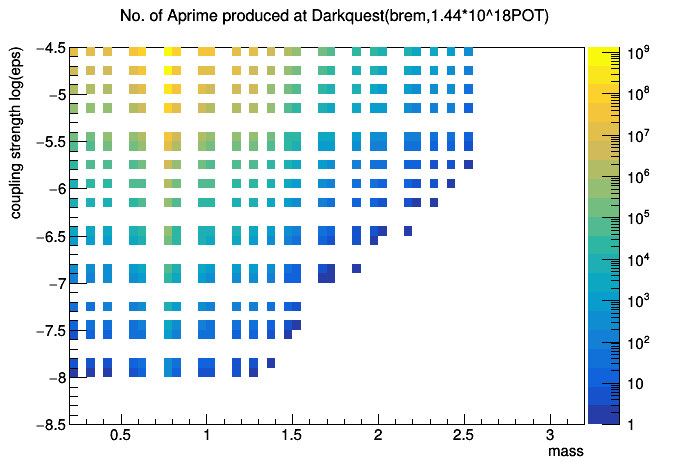

In [7]:
# plot the similar 2d histogram for cross section in order to have a visual idea.
# for brem first
eps_list = np.linspace(-4.0,-8.0,21)
mass_list = np.linspace(0.25,3.05,29)

c1 = ROOT.TCanvas("cross-section","Aprime produced")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_brem = ROOT.TH2F("cross-section","No. of Aprime produced at Darkquest(brem,1.44*10^18POT)",60,0.2,3.2,40,-8.5,-4.5)
for mass in mass_list:
    for eps in eps_list:
        if mass<0.775:
            num_gen=BremCrossSection_splineL.Eval(mass)*(10**(2*eps))/(10**(-12))
        else:
            num_gen=BremCrossSection_splineH.Eval(mass)*(10**(2*eps))/(10**(-12))
            num_gen = max(0,num_gen)      # Tspline give negative number for large mass, set to 0
        h_brem.Fill(mass,eps,num_gen)
#h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cross-section
Warning in <TROOT::Append>: Replacing existing TH1: cross-section (Potential memory leak).


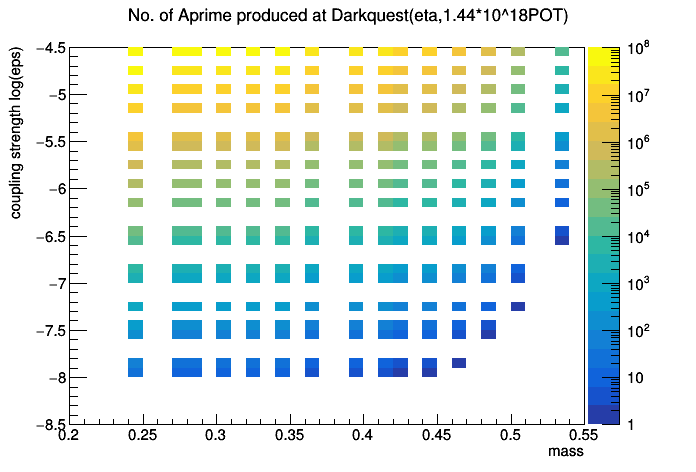

In [8]:
# for eta next
eps_list = np.linspace(-4.0,-8.0,21)
mass_list = np.linspace(0.25,0.53,15)

c1 = ROOT.TCanvas("cross-section","Aprime produced")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_eta = ROOT.TH2F("cross-section","No. of Aprime produced at Darkquest(eta,1.44*10^18POT)",35,0.2,0.55,40,-8.5,-4.5)
for mass in mass_list:
    for eps in eps_list:
        num_gen=EtaCrossSection_spline.Eval(mass)*(10**(2*eps))/(10**(-12))
        num_gen = max(0,num_gen)      # Tspline give negative number for large mass, set to 0
        h_eta.Fill(mass,eps,num_gen)
#h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_eta.Draw("colz")
h_eta.GetXaxis().SetTitle("mass")
h_eta.GetYaxis().SetTitle("coupling strength log(eps)")
h_eta.SetStats(0)
c1.Draw()

In [9]:
# calculate the ratio for A' that decay between 5-6m
# First give some functions which will be used later
def Hadron_production_ratio():
    file_name="/home/wanzj/DarkQuest/lhe/data/rpp2017-hadronicrpp_page1001.dat"
    e_cm=[]
    r_ratio=[]
    with open(file_name,'rt') as f:
        new_line=f.readline()
        while (new_line):
            #print(new_line)
            if new_line[0] != "*":
                infor=new_line.split()
                if (len(infor[0])==7):
                    
                    if (len(e_cm)>2)and(e_cm[-1]==float(infor[0])):  #reject repeated points with the same E
                        new_line=f.readline()
                        continue
                    
                    e_cm.append(float(infor[0]))
                    r_ratio.append(float(infor[3]))
                    if e_cm[-1]>10: break    #only go up to 10GeV
            new_line=f.readline()
    #print(e_cm,r_ratio)
    f.close()
    n_rpoints=len(e_cm)
    e_cm=np.array(e_cm)
    r_ratio=np.array(r_ratio)
    #print(e_cm)
    r_spline=ROOT.TSpline3("R_ratio",e_cm,r_ratio,n_rpoints,"",0.0,r_ratio[n_rpoints-1])
    return  e_cm,r_ratio,r_spline

def width_dielectron(m_aprime):
    alpha=1.0/137.036
    m_electron=5.11e-3
    massratio_sq=m_electron**2/m_aprime**2
    if m_aprime>2*m_electron:
        return (alpha*m_aprime/3)*np.sqrt(1-4*massratio_sq)*(1+2*massratio_sq)
    else: return 0

def width_dimuon(m_aprime):
    alpha=1.0/137.036
    m_muon=105.66e-3
    massratio_sq=(m_muon/m_aprime)**2
    if m_aprime>2*m_muon:
        return (alpha*m_aprime/3)*np.sqrt(1-4*massratio_sq)*(1+2*massratio_sq)
    else: return 0

def width_dihadron(m_aprime,hadron_ratio):
    alpha=1.0/137.036
    m_pion=139.57e-3
    if m_aprime>2*m_pion:
        return (alpha*m_aprime/3.0)*hadron_ratio
    else: return 0

def width_total(m_aprime,hadron_ratio):
    return width_dielectron(m_aprime)+width_dimuon(m_aprime)+width_dihadron(m_aprime,hadron_ratio)

#mean lifetime in units of cm
#must be divided by epsilon^2
def get_ctau(m_aprime,hadron_ratio):
    hbar=1.054571596e-34
    Qe=1.602176462e-19
    c=2.99792458e8
    return 100*c*hbar/(1e9*Qe*width_total(m_aprime,hadron_ratio))

def p_decay_sample(offset,decay_length,minz,maxz):
    lo=minz-offset
    hi=maxz-offset
    p=np.exp(-lo/decay_lenght)-np.exp(-hi/decay_length)
    

def decay_rate(mass,energy,eps,min_vz=500,max_vz=600):
    ctau=get_ctau(mass)/(eps**2)
    gamma=energy/mass
    beta=np.sqrt(1-1/gamma**2)
    momentum=np.sqrt(energy**2-mass**2)
    decay_length=beta*gamma*ctau
    p=np.sqrt(energy^2-mass^2)
    prob_sample=p_decay_sample(42,decay_length*energy/p,min_vz,max_vz)
    return prob_sample

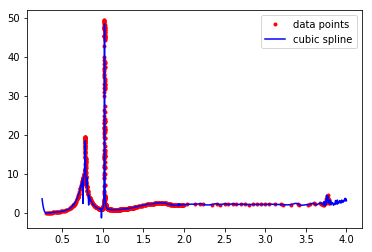

In [10]:
e_cm,r_ratio,r_spline=Hadron_production_ratio()

debug = True #print some data and draw the graph for debug mode
#debug=False
if debug:
    plt.plot(e_cm[:717],r_ratio[:717],'r.',label="data points")
    x=np.linspace(0.25,4,1000)
    y=np.zeros(1000)
    for i in range(1000):
        y[i]=r_spline.Eval(x[i])
    plt.plot(x,y,'b-',label="cubic spline")
    plt.rcParams["figure.figsize"] = (10,10)
    plt.legend()

In [10]:
class Event():
    def __init__(self,mass):
        self.ishep = 0
        self.idhep = 0
        self.phep=[0,0,0,0]  #4-momentum,mass
        self.mass=mass
    
    def simulate(self,ctau,min_vz=500,max_vz=600):
        gamma = self.phep[0]/self.mass
        beta = np.sqrt(1.0-(1.0/gamma**2))
        decay_length = beta*gamma*ctau
        #print decay_length
        p = np.sqrt(self.phep[1]**2+self.phep[2]**2+self.phep[3]**2)
        vtx_displacement = np.random.exponential(decay_length)
        vtx_production_z = 25+np.random.exponential(16.77)
        vtx_z = vtx_production_z + vtx_displacement*self.phep[3]/p
        if (vtx_z>min_vz) and (vtx_z<max_vz): return True
        return False
    
    def n_simulate(self,ctau,nturns=5,min_vz=500,max_vz=600):
        n_accepted=0
        for i in range(nturns):
            if self.simulate(ctau,min_vz,max_vz):
                n_accepted+=1
        return n_accepted

In [11]:
# calculate the decay probability through lhe file
def Displaced_events(mech,min_vz=500,max_vz=600,debug=True):
    files = glob.glob("/home/caspian/DarkQuest/lhe/data/Aprime_Muons/SeaQuestAprimeToMuonsLHE_{}*.txt".format(mech))
    eps = np.linspace(-4.0,-8.0,21)
    np.around(eps,decimals=1)
    
    mass_list = []
    eps_list = []
    dis_acc = []         #list for drawing the displaced event number seperately
    displaced_dic={}     #dictionary for calculating the total events that can be detected
    
    # Read the lhe file and record the A' to dimuon events
    for f in files:
        file_stats = os.stat(f)
        if file_stats<10000: continue
        info = f.split('_')
        mass = float(info[4])
        displaced_dic[mass]={}
        hadron_ratio = r_spline.Eval(mass)
        events=[]
        with open(f,'rt') as rfile:
            events=[]
            new_line=rfile.readline()
            while new_line:
                info=new_line.split()
                if info[0] == '666': # an Aprime event
                    event = Event(mass)
                    event.idhep = int(info[0])
                    event.ishep = int(info[1])
                    event.phep[0] =float(info[4])    #E
                    event.phep[1] =float(info[5])    #px
                    event.phep[2] =float(info[6])    #py
                    event.phep[3] =float(info[7])    #pz
                    events.append(event)
                new_line=rfile.readline()
        rfile.close()
        
        #run over the eps to calulate the decay probability
        for coupling in eps:
            coupling=round(coupling,2)
            n_accepted=0
            nturns=20   # run over several turns to reduce the statistical uncertainty
            ctau=get_ctau(mass,hadron_ratio)/(10**(2*coupling))
            for event in events:
                n_accepted+=event.n_simulate(ctau,nturns)
            mass_list.append(mass)
            eps_list.append(coupling)
            dis_acc.append(n_accepted)
            displaced_dic[mass][coupling]=float(n_accepted)/(nturns*len(events))
            if debug: print mass,coupling,n_accepted
    return displaced_dic


In [13]:
Brem_displaced = Displaced_events('Brem',500,600)
Eta_displaced = Displaced_events('Eta',500,600)
print Brem_displaced

0.55 -4.0 0
0.55 -4.2 0
0.55 -4.4 0
0.55 -4.6 0
0.55 -4.8 0
0.55 -5.0 0
0.55 -5.2 0
0.55 -5.4 7
0.55 -5.6 450
0.55 -5.8 3637
0.55 -6.0 9558
0.55 -6.2 12472
0.55 -6.4 8752
0.55 -6.6 4442
0.55 -6.8 2003
0.55 -7.0 844
0.55 -7.2 325
0.55 -7.4 144
0.55 -7.6 57
0.55 -7.8 27
0.55 -8.0 10
0.45 -4.0 0
0.45 -4.2 0
0.45 -4.4 0
0.45 -4.6 0
0.45 -4.8 0
0.45 -5.0 0
0.45 -5.2 1
0.45 -5.4 107
0.45 -5.6 1808
0.45 -5.8 7131
0.45 -6.0 12292
0.45 -6.2 10527
0.45 -6.4 5987
0.45 -6.6 2786
0.45 -6.8 1142
0.45 -7.0 453
0.45 -7.2 183
0.45 -7.4 80
0.45 -7.6 23
0.45 -7.8 11
0.45 -8.0 5
1.75 -4.0 0
1.75 -4.2 0
1.75 -4.4 0
1.75 -4.6 0
1.75 -4.8 0
1.75 -5.0 0
1.75 -5.2 0
1.75 -5.4 0
1.75 -5.6 0
1.75 -5.8 0
1.75 -6.0 6
1.75 -6.2 747
1.75 -6.4 4861
1.75 -6.6 10381
1.75 -6.8 11688
1.75 -7.0 8179
1.75 -7.2 4121
1.75 -7.4 1802
1.75 -7.6 767
1.75 -7.8 322
1.75 -8.0 112
1.65 -4.0 0
1.65 -4.2 0
1.65 -4.4 0
1.65 -4.6 0
1.65 -4.8 0
1.65 -5.0 0
1.65 -5.2 0
1.65 -5.4 0
1.65 -5.6 0
1.65 -5.8 0
1.65 -6.0 20
1.65 -6.2 976
1.65 -6

0.45 -5.0 0
0.45 -5.2 0
0.45 -5.4 2
0.45 -5.6 140
0.45 -5.8 1170
0.45 -6.0 4021
0.45 -6.2 7487
0.45 -6.4 9484
0.45 -6.6 8384
0.45 -6.8 5860
0.45 -7.0 3235
0.45 -7.2 1731
0.45 -7.4 796
0.45 -7.6 359
0.45 -7.8 175
0.45 -8.0 68
0.27 -4.0 0
0.27 -4.2 0
0.27 -4.4 0
0.27 -4.6 0
0.27 -4.8 0
0.27 -5.0 0
0.27 -5.2 10
0.27 -5.4 222
0.27 -5.6 1383
0.27 -5.8 4046
0.27 -6.0 7058
0.27 -6.2 9117
0.27 -6.4 8461
0.27 -6.6 6093
0.27 -6.8 3419
0.27 -7.0 1716
0.27 -7.2 809
0.27 -7.4 340
0.27 -7.6 121
0.27 -7.8 48
0.27 -8.0 24
0.37 -4.0 0
0.37 -4.2 0
0.37 -4.4 0
0.37 -4.6 0
0.37 -4.8 0
0.37 -5.0 0
0.37 -5.2 0
0.37 -5.4 18
0.37 -5.6 258
0.37 -5.8 1987
0.37 -6.0 5793
0.37 -6.2 8777
0.37 -6.4 9281
0.37 -6.6 7487
0.37 -6.8 4665
0.37 -7.0 2479
0.37 -7.2 1231
0.37 -7.4 515
0.37 -7.6 193
0.37 -7.8 83
0.37 -8.0 47
0.35 -4.0 0
0.35 -4.2 0
0.35 -4.4 0
0.35 -4.6 0
0.35 -4.8 0
0.35 -5.0 0
0.35 -5.2 0
0.35 -5.4 37
0.35 -5.6 422
0.35 -5.8 2267
0.35 -6.0 5749
0.35 -6.2 8632
0.35 -6.4 9061
0.35 -6.6 7306
0.35 -6.8 4713
0.

In [9]:
# Alternatively, Read the pre-generated decay probability file
Brem_displaced={}
Eta_displaced={}
with open('/home/wanzj/DarkQuest-old/e1039-analysis/SimHits/work/brem_displaced_ratio.txt') as f:
    new_line=f.readline()
    while new_line:
        info=new_line.split()
        mass=float(info[0])
        eps=float(info[1])
        ratio=float(info[2])
        if mass in Brem_displaced.keys():
            Brem_displaced[mass][eps]=ratio
        else:
            Brem_displaced[mass]={}
            Brem_displaced[mass][eps]=ratio
        new_line=f.readline()
with open('/home/wanzj/DarkQuest-old/e1039-analysis/SimHits/work/eta_displaced_ratio.txt') as f:
    new_line=f.readline()
    while new_line:
        info=new_line.split()
        mass=float(info[0])
        eps=float(info[1])
        ratio=float(info[2])
        if mass in Eta_displaced.keys():
            Eta_displaced[mass][eps]=ratio
        else:
            Eta_displaced[mass]={}
            Eta_displaced[mass][eps]=ratio
        new_line=f.readline()


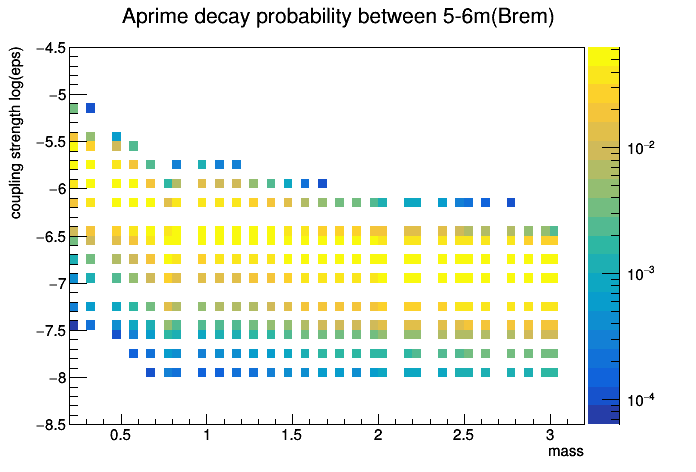

In [10]:
# plot the 3-d decay probability graph in order to compare with other method.
c1 = ROOT.TCanvas("decay-prob","Aprime decay probability between 5-6m")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_brem = ROOT.TH2F("decay-prob","Aprime decay probability between 5-6m(Brem)",60,0.2,3.2,40,-8.5,-4.5)
for mass in Brem_displaced.keys():
    for eps in Brem_displaced[mass].keys():
        h_brem.Fill(mass,eps,Brem_displaced[mass][eps])
#h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: decay-prob
Warning in <TROOT::Append>: Replacing existing TH1: decay-prob (Potential memory leak).


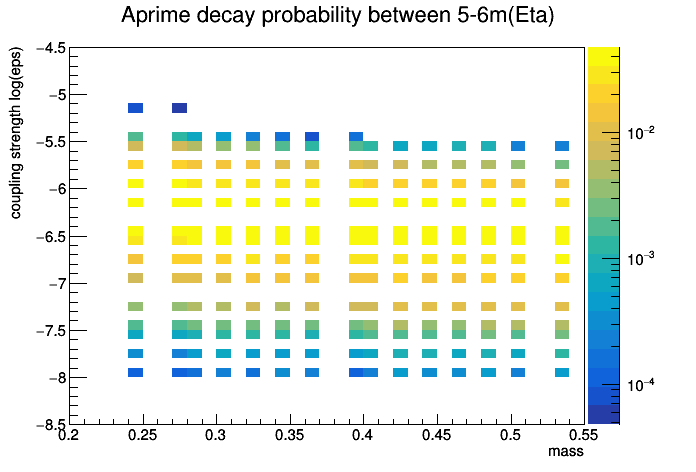

In [11]:
# plot the 3-d decay probability histogram in order to compare with other method. for eta production channel
c1 = ROOT.TCanvas("decay-prob","Aprime decay probability between 5-6m")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_eta = ROOT.TH2F("decay-prob","Aprime decay probability between 5-6m(Eta)",35,0.2,0.55,40,-8.5,-4.5)
for mass in Eta_displaced.keys():
    for eps in Eta_displaced[mass].keys():
        h_eta.Fill(mass,eps,Eta_displaced[mass][eps])
#h_eta.GetZaxis().SetRangeUser(0.0,1.0)
h_eta.Draw("colz")
h_eta.GetXaxis().SetTitle("mass")
h_eta.GetYaxis().SetTitle("coupling strength log(eps)")
h_eta.SetStats(0)
c1.Draw()

## Trigger efficiency

In [17]:
# calculate the trigger efficiency for certain output file under certain trigger conditions 
def Trigger_eff_single(f,conditions):
    rfile = TFile(f,"READ")
    if (not rfile): return 0,0,0
    t = rfile.Get("Events")
    if (not t): return 0,0,0
    den = t.GetEntries()
    #print den
    if den>200:            #get rid of those input less than 500        
        info=f.split('_')
        mass=float(info[1])
        info[-1]=info[-1][:-5]
        eps=float(info[-1])

        #get the specific eff
        num=t.GetEntries(conditions) 
        fpga_eff=float(num)/float(den)
        return mass,eps,fpga_eff
    del rfile
    del t
    return 0,0,0

# Calculate the trigger eff for all mass&eps combination for certain mechanism
def Trigger_eff_pile(mech,conditions,file_path=Caspian):
    eps_list=[]
    mass_list=[]
    fpga_eff_list=[]
    files = glob.glob((file_path+"{}*.root").format(mech))
    for f in files:
        mass,eps,fpga_eff=Trigger_eff_single(f,conditions)
        if mass !=0:
            mass_list.append(mass)
            eps_list.append(eps)
            fpga_eff_list.append(fpga_eff)
            #print mass
    return mass_list,eps_list,fpga_eff_list

In [15]:
#check the trigger eff for certain single file
root_file='/home/caspian/data/Brem_0.250000_z500_600_eps_-7.root'
#conditions="Sum$(hit_detID[]==55 || hit_detID[]==59)>3 || Sum$(hit_detID[]==56 || hit_detID[]==60)>3 || Sum$(hit_detID[]==57 || hit_detID[]==61)>3 || Sum$(hit_detID[]==58 || hit_detID[]==62)>3"
conditions="Sum$(hit_detID[]>=55 && hit_detID[]<=62)>3 & Sum$(hit_detID[]==55)==Sum$(hit_detID[]==59) & Sum$(hit_detID[]==56)==Sum$(hit_detID[]==60) & Sum$(hit_detID[]==57)==Sum$(hit_detID[]==61) & Sum$(hit_detID[]==58)==Sum$(hit_detID[]==62)"
mass,eps,eff=Trigger_eff_single(root_file,conditions)
print mass,eps,eff

NameError: global name 'TFile' is not defined

In [18]:
#old fpga trigger or 4 dp hodoscope hits
#conditions = "fpga_trigger[0]==1 || Sum$(hit_detID[]>=55 && hit_detID[]<=62)>3"
#old fpga trigger
conditions = "fpga_trigger[0]==1"
#4 dp hodoscope hits
#conditions="Sum$(hit_detID[]>=55 && hit_detID[]<=62)>3"
#4 dp hodoscope hits are all required to be in the same quadrants
#conditions="Sum$(hit_detID[]==55 || hit_detID[]==59)>3 || Sum$(hit_detID[]==56 || hit_detID[]==60)>3 || Sum$(hit_detID[]==57 || hit_detID[]==61)>3 || Sum$(hit_detID[]==58 || hit_detID[]==62)>3"
#old fpga trigger or 4 dp hodoscope hits are all required to be in the same quadrants
#conditions="fpga_trigger[0]==1 || Sum$(hit_detID[]==55 || hit_detID[]==59)>3 || Sum$(hit_detID[]==56 || hit_detID[]==60)>3 || Sum$(hit_detID[]==57 || hit_detID[]==61)>3 || Sum$(hit_detID[]==58 || hit_detID[]==62)>3"
brem_mass_list,brem_eps_list,brem_fpga_eff=Trigger_eff_pile("Brem",conditions)
eta_mass_list,eta_eps_list,eta_fpga_eff=Trigger_eff_pile('Eta',conditions)
#print brem_mass_list,brem_eps_list,brem_fpga_eff

Warning in <TFile::Init>: file /home/caspian/data/Brem_0.350000_z500_600_eps_-5.2.root probably not closed, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root, recovered key TTree:Events at address 30586752
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root, recovered key TTree:Events at address 31370748
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.450000_z500_600_eps_-7.2.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.450

### Using the pre-recorded trigger efficiency

In [12]:
# Read the trigger efficiency from the existing file
def signal_rate_read(file,mech="Brem"):
    mass_list=[]
    eps_list=[]
    trigger_eff=[]
    with open(file,'rt') as f:
        new_line=f.readline()
        while new_line:
            if new_line[0] == '/':
                info=new_line.split()
                if len(info)>5:
                    signal_file = info[0]
                    file_info=signal_file.split('_')
                    mass = float(file_info[1])
                    eps = float(file_info[-1][:-5])
                    den = int(info[1])
                    num = int(info[2])
                    signal_rate=float(num)/float(den)
                    mass_list.append(mass)
                    eps_list.append(eps)
                    trigger_eff.append(signal_rate)
            new_line=f.readline()
    return mass_list,eps_list,trigger_eff

In [24]:
signal_rate_file='/home/wanzj/dp_trigger/Signal_rates/roadset16OrMatrix1_brem.txt'
brem_mass_list,brem_eps_list,brem_fpga_eff=signal_rate_read(signal_rate_file)
signal_rate_file='/home/wanzj/dp_trigger/Signal_rates/roadset16OrMatrix1_eta.txt'
eta_mass_list,eta_eps_list,eta_fpga_eff=signal_rate_read(signal_rate_file)

### Trigger efficiency plot for two production channels

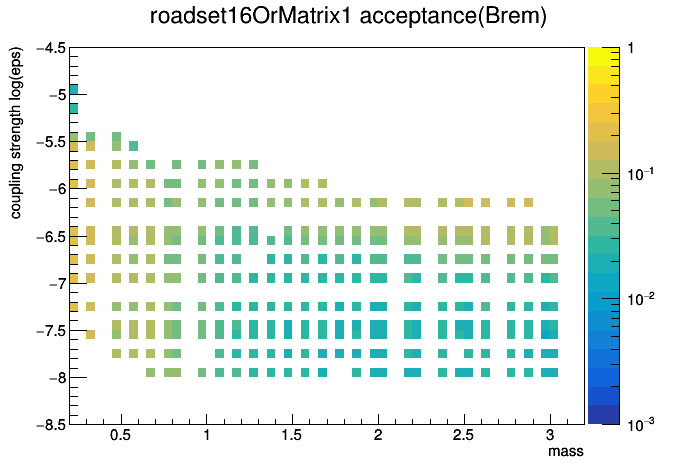

In [25]:
# draw the histogram for the eff_matrix for brem channel  
c1 = ROOT.TCanvas("eff matrix","fpga trigger efficiency")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_brem = ROOT.TH2F("fpga0","roadset16OrMatrix1 acceptance(Brem)",60,0.2,3.2,40,-8.5,-4.5)
for i in range(len(brem_eps_list)):
    h_brem.Fill(brem_mass_list[i],brem_eps_list[i],max(brem_fpga_eff[i],0.001))
h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: eff matrix
Warning in <TROOT::Append>: Replacing existing TH1: fpga0 (Potential memory leak).


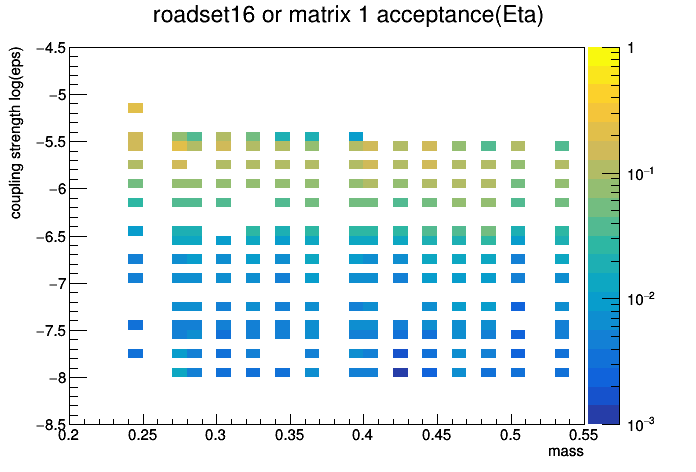

In [26]:
# draw the histogram for the eff_matrix for eta channel 
c1 = ROOT.TCanvas("eff matrix","fpga trigger efficiency")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_eta = ROOT.TH2F("fpga0","roadset16 or matrix 1 acceptance(Eta)",35,0.2,0.55,40,-8.5,-4.5)

for i in range(len(eta_eps_list)):
    h_eta.Fill(eta_mass_list[i],eta_eps_list[i],max(eta_fpga_eff[i],0.001))
h_eta.GetZaxis().SetRangeUser(0.0,1.0)
h_eta.Draw("colz")
h_eta.GetXaxis().SetTitle("mass")
h_eta.GetYaxis().SetTitle("coupling strength log(eps)")
h_eta.SetStats(0)
c1.Draw()

## Total expected events (sensitivity graph)

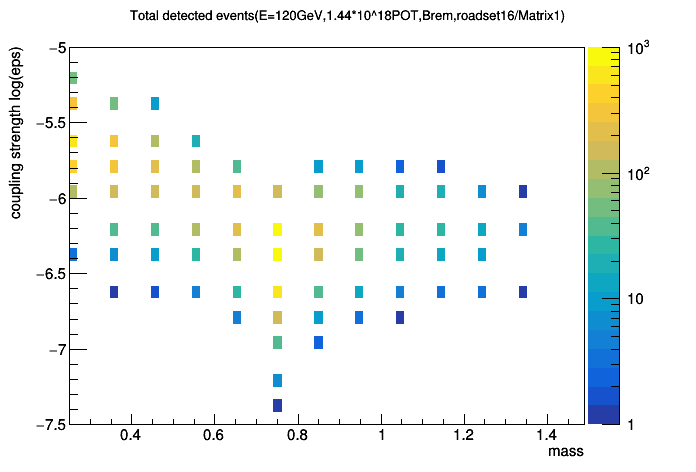

In [27]:
# Finally calculate and plot the total events we expect. N=CrossSection*L*acc(5-6m)*fpga_eff(matrix1+hodoscope)
c1 = ROOT.TCanvas("Aprime number","number of events can be detected")
c1.SetRightMargin(0.16)
c1.SetLogz()

#for brem
#h_brem = ROOT.TH2F("Brem total events","Total detected events(E=120GeV,1.44*10^18POT,Brem,roadset15/oldTrigger)",60,0.2,3.2,40,-8.5,-4.5)
#zoom in version of the graph setting
#h_brem = ROOT.TH2F("Brem total events","Total detected events(E=120GeV,1.44*10^18POT,Brem,Matrix1)",32,0.2,1.8,30,-7.5,-5)
#rebin the histogram in order to conbine two different production channel
h_brem = ROOT.TH2F("Brem total events","Total detected events(E=120GeV,1.44*10^18POT,Brem,roadset16/Matrix1)",63,0.25,1.49,30,-7.5,-5)
for j in range(len(brem_eps_list)):
    if brem_mass_list[j]<0.775:
        num_gen=BremCrossSection_splineL.Eval(brem_mass_list[j])*(10**(2*brem_eps_list[j]))/(10**(-12))
    else:
        num_gen=BremCrossSection_splineH.Eval(brem_mass_list[j])*(10**(2*brem_eps_list[j]))/(10**(-12))
    num_gen = max(0,num_gen)      # Tspline give negative number for large mass, set to 0
    num_detect=num_gen*Brem_displaced[brem_mass_list[j]][brem_eps_list[j]]*brem_fpga_eff[j]
    h_brem.Fill(brem_mass_list[j],brem_eps_list[j],num_detect)
h_brem.GetZaxis().SetRangeUser(1.0,1000.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()
#c1.SaveAs("total_detected_events_brem.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Aprime number(Eta)


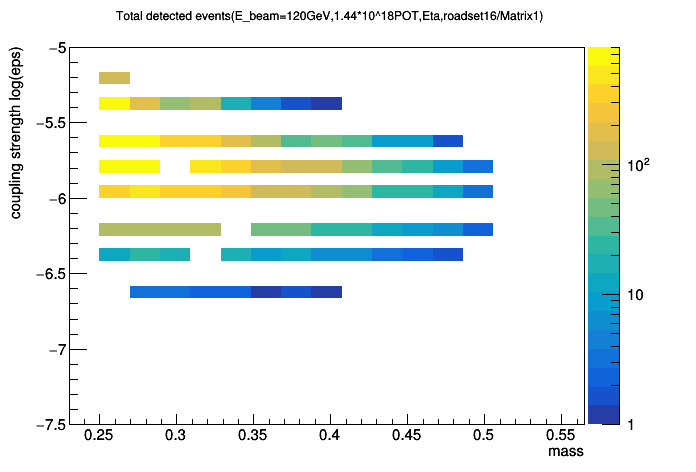

In [28]:
# Total detected events for eta production channel
c2 = ROOT.TCanvas("Aprime number(Eta)","number of events can be detected")
c2.SetRightMargin(0.16)
c2.SetLogz()

#for eta
#h_eta = ROOT.TH2F("Eta total events","Total detected events(E_beam=120GeV,1.44*10^18POT,Eta,roadset5/oldTrigger)",35,0.2,0.55,40,-8.5,-4.5)
#zoom in version of the graph setting
#h_eta = ROOT.TH2F("Eta total events","Total detected events(E_beam=120GeV,1.44*10^18POT,Eta,Matrix1)",40,0.2,0.55,30,-7.5,-5)
#rebin the histogram in order to conbine two different production channel
h_eta = ROOT.TH2F("Eta total events","Total detected events(E_beam=120GeV,1.44*10^18POT,Eta,roadset16/Matrix1)",63,0.25,1.49,30,-7.5,-5)

for j in range(len(eta_eps_list)):
    num_gen=EtaCrossSection_spline.Eval(eta_mass_list[j])*(10**(2*eta_eps_list[j]))/(10**(-12))
    num_gen = max(0,num_gen)      # Tspline give negative number for large mass, set to 0
    num_detect=num_gen*Eta_displaced[eta_mass_list[j]][eta_eps_list[j]]*eta_fpga_eff[j]
    h_eta.Fill(eta_mass_list[j],eta_eps_list[j],num_detect)
h_eta.GetZaxis().SetRangeUser(1,800)
h_eta.GetXaxis().SetRangeUser(0.2,0.55)
h_eta.Draw("colz")
h_eta.GetXaxis().SetTitle("mass")
h_eta.GetYaxis().SetTitle("coupling strength log(eps)")
h_eta.SetStats(0)
c2.Draw()
#c2.SaveAs("total_detected_events_eta.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Aprime number(Eta+Brem)
Warning in <TROOT::Append>: Replacing existing TH1: total events (Potential memory leak).


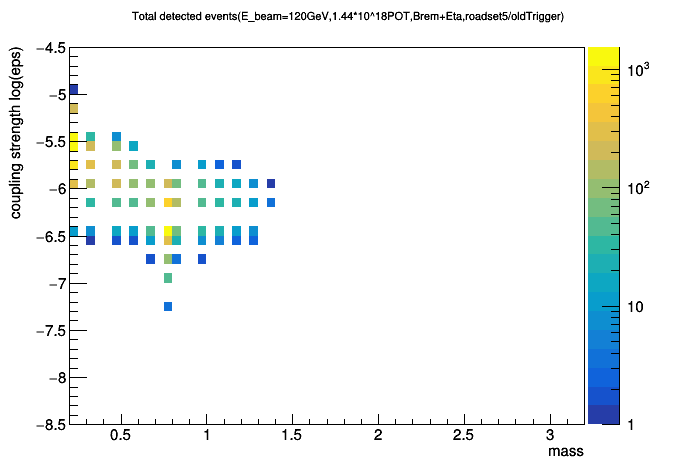

In [51]:
#For brem+eta
c3 = ROOT.TCanvas("Aprime number(Eta+Brem)","number of events can be detected")
c3.SetRightMargin(0.16)
c3.SetLogz()

# generate a dictionary for eta fpga eff at mass 0.25,0.35,0.45GeV
eta_fpgaeff_dic={0.25:{},0.35:{},0.45:{}}
for i in range((len(eta_eps_list))):
    if eta_mass_list[i]==0.25:
        eta_fpgaeff_dic[0.25][eta_eps_list[i]]=eta_fpga_eff[i]
    if eta_mass_list[i]==0.35:
        eta_fpgaeff_dic[0.35][eta_eps_list[i]]=eta_fpga_eff[i]
    if eta_mass_list[i]==0.45:
        eta_fpgaeff_dic[0.45][eta_eps_list[i]]=eta_fpga_eff[i]


h_total = ROOT.TH2F("total events","Total detected events(E_beam=120GeV,1.44*10^18POT,Brem+Eta,roadset5/oldTrigger)",60,0.2,3.2,40,-8.5,-4.5)
#zoom in version of the graph setting
#h_total = ROOT.TH2F("total events","Total detected events(E_beam=120GeV,1.44*10^18POT,Brem+Eta,roadset5/oldTrigger)",32,0.2,1.8,30,-7.5,-5)
for j in range(len(brem_eps_list)):
    if brem_mass_list[j]<0.775:
        num_gen=BremCrossSection_splineL.Eval(brem_mass_list[j])*(10**(2*brem_eps_list[j]))/(10**(-12))
    else:
        num_gen=BremCrossSection_splineH.Eval(brem_mass_list[j])*(10**(2*brem_eps_list[j]))/(10**(-12))
    num_gen = max(0,num_gen)      # Tspline give negative number for large mass, set to 0
    num_detect=num_gen*Brem_displaced[brem_mass_list[j]][brem_eps_list[j]]*brem_fpga_eff[j]
    
    # for mass=0.25,0.35,0.45 plus the A' generated in eta channel
    if brem_mass_list[j] in eta_fpgaeff_dic.keys():
        if brem_eps_list[j] in eta_fpgaeff_dic[brem_mass_list[j]].keys():
            num_gen_eta=EtaCrossSection_spline.Eval(brem_mass_list[j])*(10**(2*brem_eps_list[j]))/(10**(-12))
            num_gen_eta = max(0,num_gen_eta)      # Tspline give negative number for large mass, set to 0
            num_detect+=num_gen_eta*Eta_displaced[brem_mass_list[j]][brem_eps_list[j]]*eta_fpgaeff_dic[brem_mass_list[j]][brem_eps_list[j]]
    h_total.Fill(brem_mass_list[j],brem_eps_list[j],num_detect)

#h_total.GetZaxis().SetRangeUser(1,30000)
h_total.Draw("colz")
h_total.GetXaxis().SetTitle("mass")
h_total.GetYaxis().SetTitle("coupling strength log(eps)")
h_total.SetStats(0)
c3.Draw()
#c3.SaveAs("total_detected_events_brem+eta.png")

In [29]:
# save the 2d histogram to a root file
#outfile = TFile.Open("Expected_Events_rebin.root","RECREATE")
outfile = TFile.Open("Expected_Events_rebin.root","UPDATE")
outfile.WriteObject(h_brem,"roadset16OrMatrix1_brem")
outfile.WriteObject(h_eta,"roadset16OrMatrix1_eta")
del outfile

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Aprime number


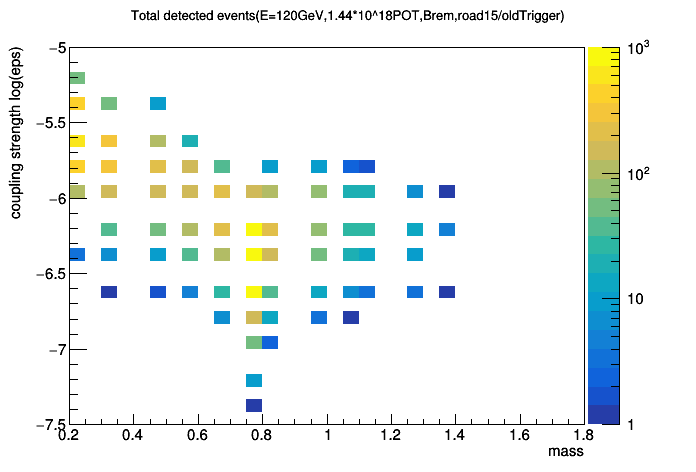

In [28]:
#test it
c1 = ROOT.TCanvas("Aprime number","number of events can be detected")
c1.SetRightMargin(0.16)
c1.SetLogz()

myFile = TFile.Open("Expected_Events.root")
hist=myFile.roadset15OrMatrix1_brem
hist.Draw("colz")
c1.Draw()

## Calculate the trigger eff based on the specific trigger roads.

In [17]:
#load the trigger road
roadset_load=np.zeros((4,80,80,50,50))
with open("/home/wanzj/dp_trigger/DPTrigger_road16.txt","rt") as f:
    new_line=f.readline()
    while new_line:
        if new_line[0]=='Q': 
            i=int(new_line[9])
            new_line=f.readline()
            continue
        info=new_line.split()   
        dp1_one=int(info[0])
        dp1_two=int(info[1])
        dp2_one=int(info[2])
        dp2_two=int(info[3])
        roadset_load[i,dp1_one,dp1_two,dp2_one,dp2_two]=float(info[4])
        new_line=f.readline()
f.close()

In [18]:
#test
TL_roadlist={}
for dp1_one in range(40):
    for dp1_two in range(40):
        for dp2_one in range(50):
            for dp2_two in range(50):
                if roadset_load[0,dp1_one,dp1_two,dp2_one,dp2_two]>0:
                    TL_roadlist[(dp1_one,dp1_two,dp2_one,dp2_two)]=roadset_load[0,dp1_one,dp1_two,dp2_one,dp2_two]
print len(TL_roadlist)
print TL_roadlist

4096
{(4, 12, 5, 22): 2.0, (12, 19, 13, 28): 5.0, (8, 12, 10, 19): 3.0, (8, 23, 8, 39): 2.0, (8, 24, 7, 40): 2.0, (8, 16, 6, 25): 2.0, (6, 10, 8, 17): 14.0, (7, 24, 5, 48): 1.0, (5, 15, 3, 24): 2.0, (10, 28, 10, 46): 2.0, (9, 27, 5, 42): 2.0, (9, 16, 8, 23): 2.0, (4, 7, 7, 11): 3.0, (15, 27, 11, 36): 2.0, (16, 20, 19, 27): 4.0, (5, 22, 2, 44): 1.0, (5, 9, 5, 16): 2.0, (7, 18, 6, 28): 1.0, (13, 18, 13, 25): 2.0, (5, 13, 6, 25): 5.0, (3, 23, 3, 45): 1.0, (6, 12, 6, 19): 10.0, (5, 18, 3, 31): 2.0, (2, 11, 5, 24): 2.0, (11, 15, 11, 22): 6.0, (2, 12, 2, 20): 1.0, (10, 27, 8, 45): 3.0, (7, 19, 8, 30): 1.0, (2, 13, 5, 25): 1.0, (14, 17, 16, 22): 6.0, (5, 16, 4, 27): 1.0, (8, 17, 10, 30): 1.0, (33, 34, 37, 42): 2.0, (7, 15, 6, 25): 4.0, (12, 16, 14, 24): 2.0, (3, 17, 4, 31): 2.0, (7, 22, 5, 36): 1.0, (7, 9, 8, 12): 1.0, (14, 25, 13, 34): 4.0, (8, 15, 6, 22): 2.0, (3, 7, 3, 11): 4.0, (1, 8, 3, 17): 8.0, (6, 27, 4, 46): 1.0, (29, 31, 34, 39): 2.0, (3, 11, 5, 23): 1.0, (1, 3, 4, 7): 4.0, (15, 28,

In [19]:
def road_trigger_signal(dp_hits,roadset,threshold=0):
    for i in range(4):
        if len(dp_hits[i])==2 & len(dp_hits[i+4])==2:
            #if roadset[i,dp_hits[i][0]-1,dp_hits[i][1]-1,dp_hits[i+4][0]-1,dp_hits[i+4][1]-1]>threshold:
            dp1_one=min(dp_hits[i][0]-1,dp_hits[i][1]-1)
            dp1_two=max(dp_hits[i][0]-1,dp_hits[i][1]-1)
            dp2_one=min(dp_hits[i+4][0]-1,dp_hits[i+4][1]-1)
            dp2_two=max(dp_hits[i+4][0]-1,dp_hits[i+4][1]-1)
            if roadset[i,dp1_one,dp1_two,dp2_one,dp2_two]>threshold:
                return True
    return False

# calculate the trigger efficiency for certain output file under certain trigger conditions 
def road_trigger_single(f,roadset,debug=True):
    rfile = TFile(f,"READ")
    if (not rfile): 
        if debug: print f
        return 0,0,0
    t = rfile.Get("Events")
    if (not t): 
        if debug: print f 
        return 0,0,0
    den = t.GetEntries()
    #print den
    if den>500:            #get rid of those input less than 500        
        info=f.split('_')
        mass=float(info[1])
        info[-1]=info[-1][:-5]
        eps=float(info[-1])

        #get the specific eff
        triggered_events_signal=[]
        for i in xrange(t.GetEntriesFast()):
            t.GetEntry(i)
            # combine w/ orignal trigger
            if t.fpga_trigger[0]==1:
                triggered_events_signal.append(i) 
                continue
            dp_hits=[[],[],[],[],[],[],[],[]]
            for hit in xrange(len(t.hit_detID)):
                if (t.hit_detID[hit]>=55) and (t.hit_detID[hit]<=62):
                    label=t.hit_detID[hit]-55
                    dp_hits[label].append(t.hit_elmID[hit])
            if road_trigger_signal(dp_hits,roadset_load,threshold=0): triggered_events_signal.append(i)
                
        if debug: print f,den,len(triggered_events_signal),triggered_events_signal[:3]
        return mass,eps,float(len(triggered_events_signal))/float(den)
    
    del rfile
    del t
    if debug: print f,den
    return 0,0,0

# Calculate the trigger eff for all mass&eps combination for certain mechanism
def road_trigger_pile(mech,roadset,file_path=Caspian):
    eps_list=[]
    mass_list=[]
    fpga_eff_list=[]
    files = glob.glob((file_path+"{}*.root").format(mech))
    for f in files:
        mass,eps,fpga_eff=road_trigger_single(f,roadset)
        if mass !=0:
            mass_list.append(mass)
            eps_list.append(eps)
            fpga_eff_list.append(fpga_eff)
            #print mass
    return mass_list,eps_list,fpga_eff_list

In [20]:
roadset=roadset_load
brem_mass_list,brem_eps_list,brem_fpga_eff=road_trigger_pile('Brem',roadset)

/home/caspian/data/Brem_0.950000_z500_600_eps_-5.6.root 28
/home/caspian/data/Brem_0.350000_z500_600_eps_-5.2.root
/home/caspian/data/Brem_0.850000_z500_600_eps_-5.8.root 2602 120 [48, 83, 85]
/home/caspian/data/Brem_0.250000_z500_600_eps_-6.4.root 10000 1859 [8, 14, 15]
/home/caspian/data/Brem_1.150000_z500_600_eps_-7.6.root 10000 313 [4, 41, 52]
/home/caspian/data/Brem_0.650000_z500_600_eps_-7.root 10000 921 [13, 23, 40]
/home/caspian/data/Brem_0.450000_z500_600_eps_-6.8.root 10000 894 [2, 6, 25]
/home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root 6279 519 [4, 25, 33]
/home/caspian/data/Brem_1.050000_z500_600_eps_-6.4.root 10000 493 [69, 78, 85]
/home/caspian/data/Brem_0.650000_z500_600_eps_-8.root 963 72 [7, 9, 10]
/home/caspian/data/Brem_0.750000_z500_600_eps_-5.8.root 118
/home/caspian/data/Brem_1.150000_z500_600_eps_-7.8.root 4148 116 [66, 70, 86]
/home/caspian/data/Brem_0.950000_z500_600_eps_-5.8.root 10000 462 [7, 9, 23]
/home/caspian/data/Brem_0.250000_z500_600_eps_-6.6.ro

/home/caspian/data/Brem_0.450000_z500_600_eps_-6.4.root 10000 899 [21, 25, 28]
/home/caspian/data/Brem_0.850000_z500_600_eps_-7.root 10000 629 [5, 9, 21]
/home/caspian/data/Brem_0.650000_z500_600_eps_-6.6.root 10000 1025 [2, 19, 24]
/home/caspian/data/Brem_0.850000_z500_600_eps_-8.root 1740 110 [1, 35, 37]
/home/caspian/data/Brem_1.350000_z500_600_eps_-5.8.root 141
/home/caspian/data/Brem_1.250000_z500_600_eps_-7.root 10000 268 [52, 82, 109]
/home/caspian/data/Brem_0.750000_z500_600_eps_-7.8.root 7333 546 [1, 2, 13]
/home/caspian/data/Brem_1.250000_z500_600_eps_-8.root 2046 63 [20, 32, 72]
/home/caspian/data/Brem_1.450000_z500_600_eps_-5.8.root 6
/home/caspian/data/Brem_0.950000_z500_600_eps_-7.root 10000 524 [9, 36, 59]
/home/caspian/data/Brem_0.250000_z500_600_eps_-5.6.root 10000 1600 [2, 6, 7]
/home/caspian/data/Brem_0.350000_z500_600_eps_-8.root 152
/home/caspian/data/Brem_0.950000_z500_600_eps_-8.root 1271 62 [13, 23, 38]
/home/caspian/data/Brem_1.150000_z500_600_eps_-6.4.root 100

/home/caspian/data/Brem_1.750000_z500_600_eps_-6.6.root 10000 545 [17, 25, 51]
/home/caspian/data/Brem_1.450000_z500_600_eps_-7.root 10000 242 [28, 44, 57]
/home/caspian/data/Brem_2.050000_z500_600_eps_-7.4.root 10000 197 [78, 124, 131]
/home/caspian/data/Brem_1.550000_z500_600_eps_-7.root 10000 276 [22, 50, 55]
/home/caspian/data/Brem_1.450000_z500_600_eps_-8.root 3563 95 [45, 109, 180]
/home/caspian/data/Brem_1.850000_z500_600_eps_-7.root 10000 241 [25, 106, 134]
/home/caspian/data/Brem_2.350000_z500_600_eps_-6.6.root 10000 775 [1, 5, 6]
/home/caspian/data/Brem_1.550000_z500_600_eps_-8.root 4674 118 [15, 17, 43]
/home/caspian/data/Brem_2.550000_z500_600_eps_-6.2.root 1893 255 [13, 46, 51]
/home/caspian/data/Brem_1.950000_z500_600_eps_-7.8.root 10000 208 [56, 67, 93]
/home/caspian/data/Brem_2.150000_z500_600_eps_-7.root 10000 324 [1, 106, 107]
/home/caspian/data/Brem_2.450000_z500_600_eps_-6.4.root 10000 1081 [4, 7, 10]
/home/caspian/data/Brem_2.050000_z500_600_eps_-7.6.root 8463 154 

/home/caspian/data/Brem_3.050000_z500_600_eps_-7.6.root 10000 216 [31, 130, 165]
/home/caspian/data/Brem_2.950000_z500_600_eps_-7.8.root 10000 163 [93, 137, 139]
/home/caspian/data/Brem_2.750000_z500_600_eps_-6.6.root 10000 1028 [6, 16, 20]
/home/caspian/data/Brem_2.850000_z500_600_eps_-7.8.root 9975 209 [8, 80, 134]
/home/caspian/data/Brem_3.050000_z500_600_eps_-7.8.root 10000 210 [3, 43, 50]
/home/caspian/data/Brem_2.950000_z500_600_eps_-7.root 10000 267 [41, 92, 159]
/home/caspian/data/Brem_2.850000_z500_600_eps_-7.root 10000 366 [19, 29, 43]
/home/caspian/data/Brem_2.750000_z500_600_eps_-6.8.root 10000 620 [14, 28, 37]
/home/caspian/data/Brem_3.050000_z500_600_eps_-7.root 10000 369 [8, 11, 50]
/home/caspian/data/Brem_2.950000_z500_600_eps_-8.root 10000 165 [197, 282, 320]
/home/caspian/data/Brem_2.850000_z500_600_eps_-8.root 10000 231 [179, 180, 240]
/home/caspian/data/Brem_2.750000_z500_600_eps_-7.2.root 10000 297 [32, 152, 165]
/home/caspian/data/Brem_3.050000_z500_600_eps_-8.roo

Warning in <TFile::Init>: file /home/caspian/data/Brem_0.350000_z500_600_eps_-5.2.root probably not closed, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root, recovered key TTree:Events at address 30586752
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root, recovered key TTree:Events at address 31370748
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.450000_z500_600_eps_-7.2.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.450

In [23]:
%time
eta_mass_list,eta_eps_list,eta_fpga_eff=road_trigger_pile('Eta',roadset)

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 21.9 µs
/home/caspian/data/Eta_0.250000_z500_600_eps_-6.2.root 10000 292 [15, 69, 79]
/home/caspian/data/Eta_0.310000_z500_600_eps_-5.2.root 43
/home/caspian/data/Eta_0.270000_z500_600_eps_-7.2.root 10000 68 [425, 465, 600]
/home/caspian/data/Eta_0.310000_z500_600_eps_-5.4.root 3443 393 [0, 4, 7]
/home/caspian/data/Eta_0.250000_z500_600_eps_-6.4.root 10000 104 [18, 103, 142]
/home/caspian/data/Eta_0.250000_z500_600_eps_-6.6.root
/home/caspian/data/Eta_0.270000_z500_600_eps_-7.4.root 10000 50 [157, 241, 243]
/home/caspian/data/Eta_0.250000_z500_600_eps_-6.8.root 10000 45 [4, 69, 781]
/home/caspian/data/Eta_0.270000_z500_600_eps_-7.6.root 7020 32 [158, 176, 185]
/home/caspian/data/Eta_0.270000_z500_600_eps_-7.8.root 2626 21 [68, 146, 268]
/home/caspian/data/Eta_0.310000_z500_600_eps_-5.6.root 10000 1343 [2, 14, 29]
/home/caspian/data/Eta_0.270000_z500_600_eps_-7.root 10000 78 [51, 343, 390]
/home/caspian/data/Eta_0.250000_z500_600

/home/caspian/data/Eta_0.470000_z500_600_eps_-6.6.root 10000 218 [32, 159, 165]
/home/caspian/data/Eta_0.430000_z500_600_eps_-5.8.root 10000 977 [1, 18, 29]
/home/caspian/data/Eta_0.410000_z500_600_eps_-5.8.root 10000 1414 [9, 26, 28]
/home/caspian/data/Eta_0.490000_z500_600_eps_-7.8.root 9029 42 [571, 1200, 1297]
/home/caspian/data/Eta_0.370000_z500_600_eps_-7.root 10000 89 [93, 135, 313]
/home/caspian/data/Eta_0.370000_z500_600_eps_-8.root 1844 13 [79, 86, 258]
/home/caspian/data/Eta_0.390000_z500_600_eps_-5.2.root 14
/home/caspian/data/Eta_0.470000_z500_600_eps_-6.8.root 10000 143 [37, 127, 176]
/home/caspian/data/Eta_0.450000_z500_600_eps_-6.2.root 10000 623 [4, 28, 33]
/home/caspian/data/Eta_0.390000_z500_600_eps_-5.4.root 1494 16 [115, 200, 362]
/home/caspian/data/Eta_0.490000_z500_600_eps_-7.root 10000 83 [33, 77, 192]
/home/caspian/data/Eta_0.410000_z500_600_eps_-6.2.root 10000 498 [0, 36, 37]
/home/caspian/data/Eta_0.430000_z500_600_eps_-6.2.root 10000 426 [2, 3, 25]
/home/cas

Error in <TFile::ReadBuffer>: error reading all requested bytes from file /home/caspian/data/Eta_0.250000_z500_600_eps_-6.6.root, got 218 of 300
Error in <TFile::Init>: /home/caspian/data/Eta_0.250000_z500_600_eps_-6.6.root failed to read the file type data.
Warning in <TFile::Init>: file /home/caspian/data/Eta_0.250000_z500_600_eps_-7.2.root probably not closed, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie
Warning in <TFile::Init>: file /home/caspian/data/Eta_0.250000_z500_600_eps_-7.6.root probably not closed, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie
Error in <TFile::ReadBuffer>: error reading all requested bytes from file /home/caspian/data/Eta_0.290000_z500_600_eps_-5.8.root, got 218 of 300
Error in <TFile::Init>: /home/caspian/data/Eta_0.290000_z500_600_eps_-5.8.root failed to read the file type data.
Warning in <TFile::Init>: file /home/caspian/data/Eta_0.290000_z500_600_eps_-5.root pr

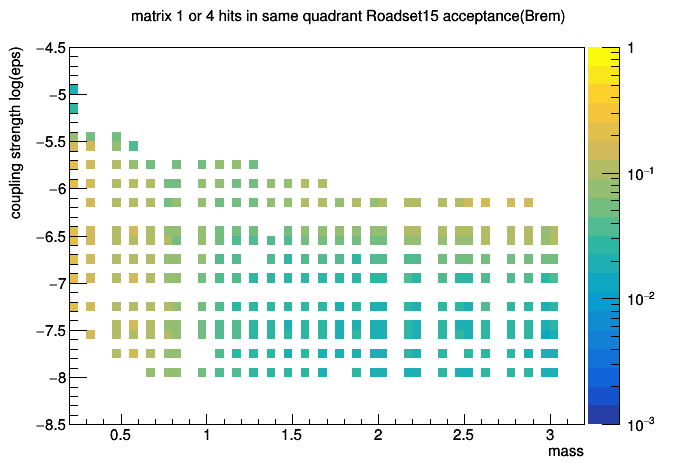

In [15]:
# draw the histogram for the eff_matrix for brem channel  
c1 = ROOT.TCanvas("eff matrix","fpga trigger efficiency")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_brem = ROOT.TH2F("fpga0","matrix 1 or 4 hits in same quadrant Roadset15 acceptance(Brem)",60,0.2,3.2,40,-8.5,-4.5)
for i in range(len(brem_eps_list)):
    h_brem.Fill(brem_mass_list[i],brem_eps_list[i],max(brem_fpga_eff[i],0.001))
h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()

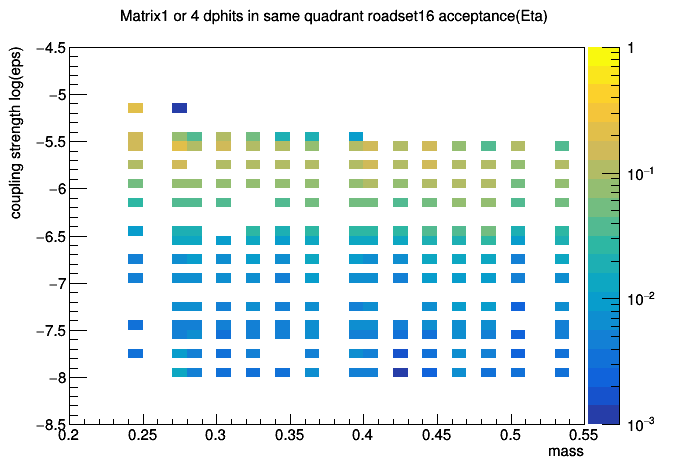

In [24]:
# draw the histogram for the eff_matrix for eta channel 
c1 = ROOT.TCanvas("eff matrix","fpga trigger efficiency")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_eta = ROOT.TH2F("fpga0","Matrix1 or 4 dphits in same quadrant roadset16 acceptance(Eta)",35,0.2,0.55,40,-8.5,-4.5)

for i in range(len(eta_eps_list)):
    h_eta.Fill(eta_mass_list[i],eta_eps_list[i],max(eta_fpga_eff[i],0.001))
h_eta.GetZaxis().SetRangeUser(0.0,1.0)
h_eta.Draw("colz")
h_eta.GetXaxis().SetTitle("mass")
h_eta.GetYaxis().SetTitle("coupling strength log(eps)")
h_eta.SetStats(0)
c1.Draw()

In [21]:
print eta_fpgaeff_dic.keys()

[0.25, 0.35, 0.45]


In [24]:
x=np.linspace(-4.0,-8.0,21)
print x

[-4.  -4.2 -4.4 -4.6 -4.8 -5.  -5.2 -5.4 -5.6 -5.8 -6.  -6.2 -6.4 -6.6
 -6.8 -7.  -7.2 -7.4 -7.6 -7.8 -8. ]


In [33]:
print 10**7.406403763525514

25491991.4136


In [34]:
print BremCrossSection_splineH.Eval(3)

-34.1813150991


Warning in <TCanvas::Constructor>: Deleting canvas with same name: eff matrix
Warning in <TROOT::Append>: Replacing existing TH1: fpga0 (Potential memory leak).


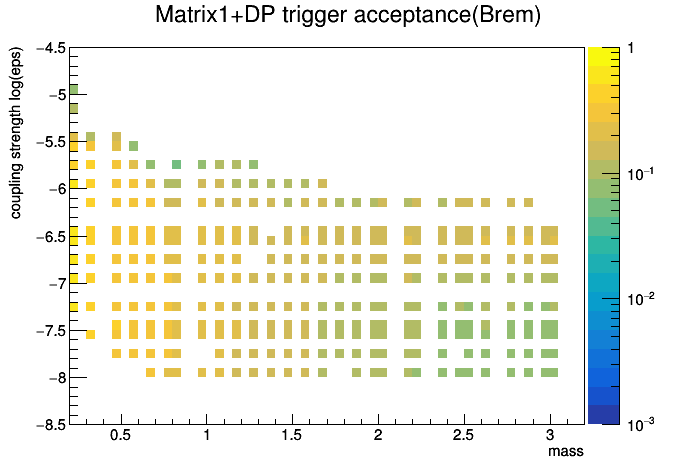

In [6]:
# draw the histogram for the eff_matrix   
c1 = ROOT.TCanvas("eff matrix","fpga trigger efficiency")
c1.SetRightMargin(0.16)
c1.SetLogz()
h_brem = ROOT.TH2F("fpga0","Matrix1+DP trigger acceptance(Brem)",60,0.2,3.2,40,-8.5,-4.5)

for i in range(len(brem_eps_list)):
    h_brem.Fill(brem_mass_list[i],brem_eps_list[i],max(brem_fpga_eff[i],0.001))
h_brem.GetZaxis().SetRangeUser(0.0,1.0)
h_brem.Draw("colz")
h_brem.GetXaxis().SetTitle("mass")
h_brem.GetYaxis().SetTitle("coupling strength log(eps)")
h_brem.SetStats(0)
c1.Draw()

In [7]:
for i in range(len(brem_eps_list)):
    print brem_mass_list[i],brem_eps_list[i],brem_fpga_eff[i]

0.85 -5.8 0.0561106840892
0.25 -6.4 0.5213
1.15 -7.6 0.178
0.65 -7.0 0.2856
0.45 -6.8 0.3454
0.55 -6.8 0.317247969422
1.05 -6.4 0.2053
0.65 -8.0 0.285565939772
1.15 -7.8 0.172613307618
0.95 -5.8 0.0636
0.25 -6.6 0.5195
0.85 -6.2 0.1572
0.35 -5.4 0.1239
1.05 -6.6 0.205
1.15 -7.0 0.1911
0.45 -6.0 0.3269
0.55 -6.0 0.286911345735
1.15 -8.0 0.175045427014
0.25 -6.8 0.5287
1.25 -5.8 0.0710128055879
0.75 -6.2 0.146
0.85 -6.4 0.2039
0.95 -6.2 0.1888
1.05 -6.8 0.1916
0.45 -7.2 0.347890818859
0.35 -5.6 0.2815
0.25 -6.0 0.505
0.55 -7.2 0.3238
0.25 -7.2 0.539923954373
1.25 -6.2 0.1337
0.75 -6.4 0.2313
0.85 -6.6 0.210551181102
0.95 -6.4 0.2206
0.55 -7.4 0.314140050982
0.25 -7.0 0.535751475182
0.35 -6.2 0.4618
0.55 -7.6 0.317269076305
0.55 -7.8 0.338461538462
1.05 -6.0 0.1259
0.35 -5.8 0.411
0.45 -7.4 0.354626708728
1.25 -6.4 0.1723
0.85 -6.8 0.2184
0.75 -6.6 0.2501
0.95 -6.6 0.2143
1.05 -7.2 0.1973
0.45 -5.4 0.128376008418
0.55 -7.0 0.3214
0.35 -6.8 0.464
0.35 -6.4 0.469
1.25 -6.6 0.1694
0.45 -7.6 

In [9]:
conditions = "fpga_trigger[0]==1"
brem_mass_list,brem_eps_list,brem_fpga_eff=Trigger_eff_pile("Brem",conditions)
for i in range(len(brem_eps_list)):
    print brem_mass_list[i],brem_eps_list[i],brem_fpga_eff[i]

0.85 -5.8 0.04381245196
0.25 -6.4 0.0028
1.15 -7.6 0.0157
0.65 -7.0 0.0134
0.45 -6.8 0.0182
0.55 -6.8 0.00955566172957
1.05 -6.4 0.0314
0.65 -8.0 0.0114226375909
1.15 -7.8 0.0122950819672
0.95 -5.8 0.0426
0.25 -6.6 0.0027
0.85 -6.2 0.0318
0.35 -5.4 0.0033
1.05 -6.6 0.025
1.15 -7.0 0.0169
0.45 -6.0 0.0214
0.55 -6.0 0.0164236634825
1.15 -8.0 0.0163537250151
0.25 -6.8 0.0036
1.25 -5.8 0.0570430733411
0.75 -6.2 0.0227
0.85 -6.4 0.0231
0.95 -6.2 0.0382
1.05 -6.8 0.0202
0.45 -7.2 0.0177005789909
0.35 -5.6 0.0103
0.25 -6.0 0.0027
0.55 -7.2 0.0082
0.25 -7.2 0.00380228136882
1.25 -6.2 0.0424
0.75 -6.4 0.0209
0.85 -6.6 0.0182677165354
0.95 -6.4 0.0321
0.55 -7.4 0.0106462738042
0.25 -7.0 0.00242971190559
0.35 -6.2 0.0116
0.55 -7.6 0.00620664476086
0.55 -7.8 0.00904977375566
1.05 -6.0 0.0581
0.35 -5.8 0.0138
0.45 -7.4 0.0173501577287
1.25 -6.4 0.0295
0.85 -6.8 0.0148
0.75 -6.6 0.0118
0.95 -6.6 0.0258
1.05 -7.2 0.0208
0.45 -5.4 0.0224482637671
0.55 -7.0 0.0093
0.35 -6.8 0.0114
0.35 -6.4 0.0123
1.25

Warning in <TFile::Init>: file /home/caspian/data/Brem_0.350000_z500_600_eps_-5.2.root probably not closed, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.8.root, recovered key TTree:Events at address 30586752
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.550000_z500_600_eps_-6.root, recovered key TTree:Events at address 31370748
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /home/caspian/data/Brem_0.450000_z500_600_eps_-7.2.root probably not closed, trying to recover
Info in <TFile::Recover>: /home/caspian/data/Brem_0.450

In [37]:
with open("brem_displaced_ratio.txt",'wt') as f:
    for mass in Brem_displaced.keys():
        for eps in Brem_displaced[mass].keys():
            f.write(str(mass)+'\t'+str(eps)+'\t'+str(Brem_displaced[mass][eps])+'\n')
#f.close()

with open("eta_displaced_ratio.txt",'wt') as f:
    for mass in Eta_displaced.keys():
        for eps in Eta_displaced[mass].keys():
            f.write(str(mass)+'\t'+str(eps)+'\t'+str(Eta_displaced[mass][eps])+'\n')
#f.close()

{u'2.85': {u'-6.2': 3.5e-05, u'-6.0': 0.0, u'-6.6': 0.02875, u'-7.8': 0.003525, u'-6.4': 0.005005, u'-7.6': 0.007975, u'-7.4': 0.01875, u'-6.8': 0.054835, u'-7.2': 0.03745, u'-8.0': 0.00119, u'-7.0': 0.057325, u'-4.0': 0.0, u'-4.2': 0.0, u'-5.8': 0.0, u'-4.4': 0.0, u'-4.6': 0.0, u'-5.4': 0.0, u'-4.8': 0.0, u'-5.6': 0.0, u'-5.0': 0.0, u'-5.2': 0.0}, u'0.45': {u'-6.2': 0.052635, u'-6.0': 0.06146, u'-6.6': 0.01393, u'-7.8': 5.5e-05, u'-6.4': 0.029935, u'-7.6': 0.000115, u'-7.4': 0.0004, u'-6.8': 0.00571, u'-7.2': 0.000915, u'-8.0': 2.5e-05, u'-7.0': 0.002265, u'-4.0': 0.0, u'-4.2': 0.0, u'-5.8': 0.035655, u'-4.4': 0.0, u'-4.6': 0.0, u'-5.4': 0.000535, u'-4.8': 0.0, u'-5.6': 0.00904, u'-5.0': 0.0, u'-5.2': 5e-06}, u'0.65': {u'-6.2': 0.052755, u'-6.0': 0.02177, u'-6.6': 0.04046, u'-7.8': 0.0002, u'-6.4': 0.063005, u'-7.6': 0.000535, u'-7.4': 0.00124, u'-6.8': 0.020435, u'-7.2': 0.00367, u'-8.0': 9e-05, u'-7.0': 0.00897, u'-4.0': 0.0, u'-4.2': 0.0, u'-5.8': 0.00278, u'-4.4': 0.0, u'-4.6': 0.

In [32]:
print Brem_displaced

{1.75: {-7.8: 0.00161, -6.2: 0.003735, -7.6: 0.003835, -7.2: 0.020605, -4.6: 0.0, -5.6: 0.0, -6.6: 0.051905, -4.2: 0.0, -5.2: 0.0, -7.4: 0.00901, -6.0: 3e-05, -7.0: 0.040895, -4.8: 0.0, -6.8: 0.05844, -8.0: 0.00056, -5.8: 0.0, -4.4: 0.0, -5.0: 0.0, -4.0: 0.0, -5.4: 0.0, -6.4: 0.024305}, 2.25: {-7.8: 0.002135, -6.2: 0.000885, -7.6: 0.0051, -7.2: 0.026815, -4.6: 0.0, -5.6: 0.0, -6.6: 0.043015, -4.2: 0.0, -5.2: 0.0, -7.4: 0.011735, -6.0: 0.0, -7.0: 0.04772, -4.8: 0.0, -6.8: 0.05845, -8.0: 0.000845, -5.8: 0.0, -4.4: 0.0, -5.0: 0.0, -4.0: 0.0, -5.4: 0.0, -6.4: 0.01458}, 1.45: {-7.8: 0.000965, -6.2: 0.012225, -7.6: 0.002275, -7.2: 0.01273, -4.6: 0.0, -5.6: 0.0, -6.6: 0.06176, -4.2: 0.0, -5.2: 0.0, -7.4: 0.005385, -6.0: 0.00073, -7.0: 0.02808, -4.8: 0.0, -6.8: 0.05058, -8.0: 0.000385, -5.8: 0.0, -4.4: 0.0, -5.0: 0.0, -4.0: 0.0, -5.4: 0.0, -6.4: 0.03915}, 0.25: {-7.8: 1e-05, -6.2: 0.020175, -7.6: 3.5e-05, -7.2: 0.000255, -4.6: 0.0, -5.6: 0.052695, -6.6: 0.003485, -4.2: 0.0, -5.2: 0.00356, -7.4

In [18]:
import uproot